## LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Add the 'src' folder to the Python path
sys.path.append(os.path.abspath('../02_Src'))

from feature_engineering import apply_adstock, add_seasonal_features, add_division_dummies
from modeling import run_linear_model, full_grid_search_with_adstock
from analysis import plot_feature_importance
from simulation import simulate_budget_shift

### 1. Load data

In [2]:
df = pd.read_csv('../03_Data/02_Processed/media_spend_final_features.csv')
df['Calendar_Week'] = pd.to_datetime(df['Calendar_Week'])

# Add seasonal & holiday features
df = add_seasonal_features(df)
df = add_division_dummies(df)
df['is_covid'] = (df['Calendar_Week'] >= '2020-03-01').astype(int)

In [3]:
# Create Sales_demeaned for modeling
df['Sales_demeaned'] = df['Sales'] - df.groupby('Division')['Sales'].transform('mean')

In [4]:
df.head()

,Division,Calendar_Week,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales,...,div_S,div_T,div_U,div_V,div_W,div_X,div_Y,div_Z,is_covid,Sales_demeaned
0,A,2018-01-06,392,422,408,349895.0107,73580,12072,682,59417,...,False,False,False,False,False,False,False,False,0,-43974.238938
1,A,2018-01-13,787,904,110,506270.2176,11804,9499,853,56806,...,False,False,False,False,False,False,False,False,0,-46585.238938
2,A,2018-01-20,81,970,742,430042.1538,52232,17048,759,48715,...,False,False,False,False,False,False,False,False,0,-54676.238938
3,A,2018-01-27,25,575,65,417745.6658,78640,10207,942,72047,...,False,False,False,False,False,False,False,False,0,-31344.238938
4,A,2018-02-03,565,284,295,408505.8012,40561,5834,658,56235,...,False,False,False,False,False,False,False,False,0,-47156.238938


In [5]:
# Media + static features

In [6]:
media_channels = [
    'Facebook_Impressions', 'Google_Impressions',
    'Email_Impressions', 'Affiliate_Impressions', 'Paid_Views'
]

static_features = [
    'week_sin', 'week_cos', 'is_black_friday',
    'is_christmas', 'is_easter', 'is_covid'
] + [col for col in df.columns if col.startswith('div_')]

In [7]:
# Time-based train/test split

In [8]:
df = df.sort_values('Calendar_Week')
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx].copy()
df_test = df.iloc[split_idx:].copy()

In [9]:
# Define XGBoost and adstock search grids

In [14]:
xgb_param_grid = {
    'n_estimators': [ 200, 250, 300, 400, 500],
    'max_depth': [3, 4, 7, 9, 11],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

decay_grid = np.arange(0.1, 1.0, 0.1)

In [15]:
# Run full grid search

In [16]:
search_result = full_grid_search_with_adstock(
    df=df,
    base_cols=media_channels,
    static_features=static_features,
    decay_grid=[0.3, 0.5, 0.7, 0.9],
    xgb_param_grid=xgb_param_grid,
    use_log=True  
)

 Best decay: 0.9
 Best XGBoost Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 400, 'subsample': 1.0}
 Best CV R² using log(adstock): 0.6172


In [17]:
search_result_raw = full_grid_search_with_adstock(
    df=df,
    base_cols=media_channels,
    static_features=static_features,
    decay_grid=[0.3, 0.5, 0.7, 0.9],
    xgb_param_grid=xgb_param_grid,
    use_log=False  
)

 Best decay: 0.9
 Best XGBoost Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 400, 'subsample': 1.0}
 Best CV R² using raw adstock: 0.6178


In [ ]:
# Define those parameters

In [18]:
best_decay = 0.9

best_xgb_params = {
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_child_weight': 10,
    'n_estimators': 400,
    'subsample': 1.0
}

In [19]:
# Reapply adstock using this decay

In [20]:
for col in media_channels:
    df_train[f'{col}_adstock'] = apply_adstock(df_train[col], best_decay)
    df_test[f'{col}_adstock'] = apply_adstock(df_test[col], best_decay)

In [21]:
# Define features

In [22]:
features_final = [f"{col}_adstock" for col in media_channels] + static_features

In [23]:
# Train the model with those params

In [24]:
X_train = df_train[features_final]
y_train = df_train['Sales_demeaned']

X_test = df_test[features_final]
y_test = df_test['Sales_demeaned']

best_model = XGBRegressor(**best_xgb_params, random_state=42)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
# Evaluate on test set

In [26]:
y_pred = best_model.predict(X_test)

print("\n Test Set Performance :")
print(f"R²   = {r2_score(y_test, y_pred):.4f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"MAE  = {mean_absolute_error(y_test, y_pred):.2f}")


 Test Set Performance :
R²   = 0.2378
RMSE = 128971.65
MAE  = 87901.75


In [28]:
# Additional check

In [27]:
# Set fixed decay
decay = 0.9

# Create raw and log adstock features
for col in media_channels:
    df_train[f'{col}_adstock'] = apply_adstock(df_train[col], decay=decay)
    df_test[f'{col}_adstock'] = apply_adstock(df_test[col], decay=decay)
    
    df_train[f'{col}_adstock_log'] = np.log1p(df_train[f'{col}_adstock'])
    df_test[f'{col}_adstock_log'] = np.log1p(df_test[f'{col}_adstock'])

# Define feature sets
features_raw = [f"{col}_adstock" for col in media_channels] + static_features
features_log = [f"{col}_adstock_log" for col in media_channels] + static_features

# Targets
y_train = df_train['Sales_demeaned']
y_test = df_test['Sales_demeaned']

# Train models
model_raw = XGBRegressor(random_state=42).fit(df_train[features_raw], y_train)
model_log = XGBRegressor(random_state=42).fit(df_train[features_log], y_train)

# Predict and score
r2_raw = r2_score(y_test, model_raw.predict(df_test[features_raw]))
r2_log = r2_score(y_test, model_log.predict(df_test[features_log]))

# Print results
print(f" Raw Adstock R²: {r2_raw:.4f}")
print(f" Log Adstock R²: {r2_log:.4f}")


 Raw Adstock R²: 0.2973
 Log Adstock R²: 0.2902


With a fixed adstock decay of 0.9, raw adstock features outperform log-transformed ones, yielding an R² of 0.2973 vs 0.2902.
This suggests that the model benefits more from preserving the original scale of media impact rather than compressing it via a logarithmic transformation.
Therefore, I proceed with raw adstock features for better predictive accuracy and interpretability

In [29]:
# Feature importance

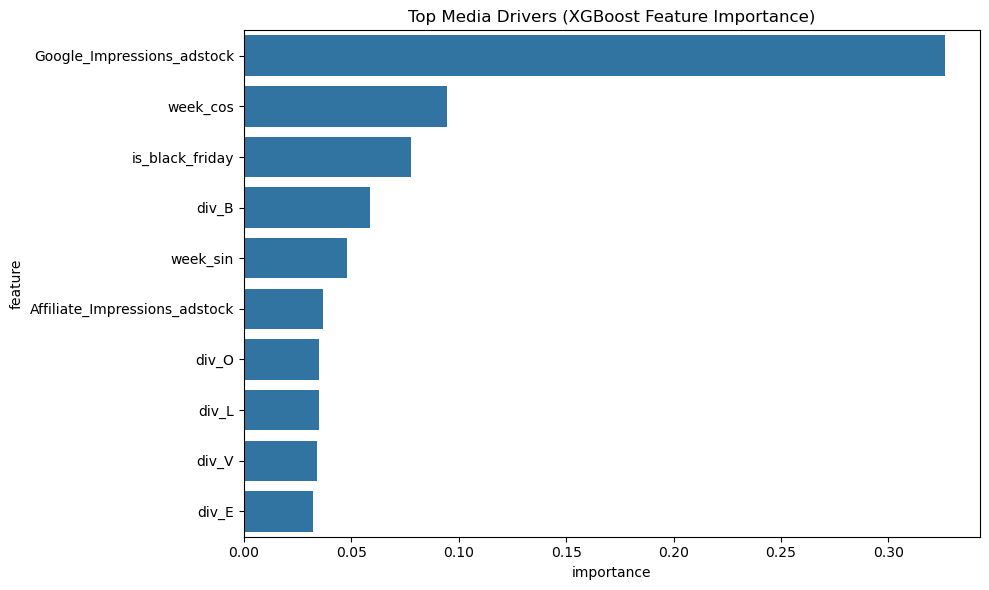

In [30]:
importance_df = pd.DataFrame({
    'feature': features_final,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)
plot_feature_importance(importance_df)

In [31]:
importance_df

,feature,importance
1,Google_Impressions_adstock,0.326276
6,week_cos,0.094613
7,is_black_friday,0.077986
11,div_B,0.058680
5,week_sin,0.048005
3,Affiliate_Impressions_adstock,0.036723
24,div_O,0.034883
21,div_L,0.034811
31,div_V,0.033983
14,div_E,0.032304


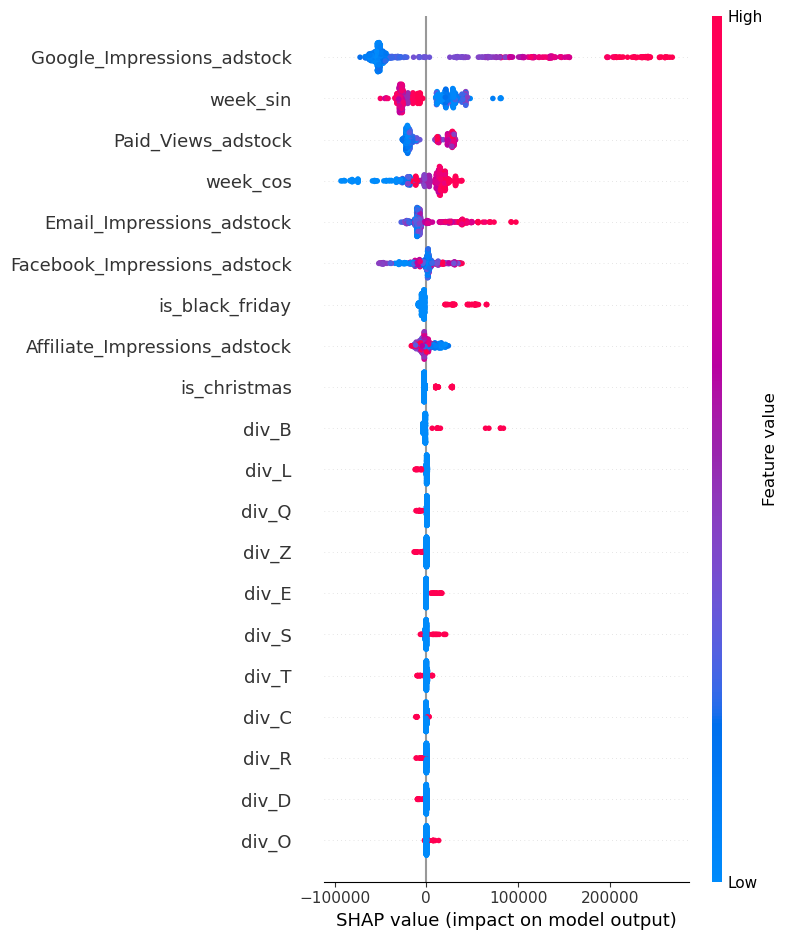

In [32]:
# Ensure correct features and types
X_test = df_test[features_final].copy()
X_test = X_test.astype(np.float64)

import shap
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Beeswarm plot
shap.summary_plot(shap_values, X_test)

## Channel Effect Ranking

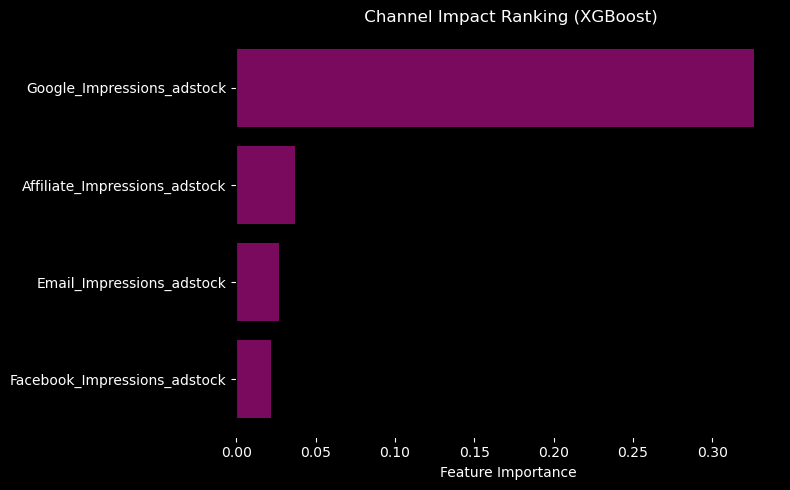

In [33]:
importances = best_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': features_final,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Filter media channels only
media_importance = importance_df[importance_df['feature'].str.contains('Impressions_adstock')]

custom_color = '#790A5D'

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 5), facecolor='black')
ax.barh(media_importance['feature'], media_importance['importance'], color=custom_color)
ax.set_facecolor('black')
ax.set_xlabel("Feature Importance", color='white')
ax.set_title(" Channel Impact Ranking (XGBoost)", color='white')
ax.tick_params(colors='white')
plt.gca().invert_yaxis()
plt.tight_layout()

# Save the figure
plt.savefig("../04_Output/05_Plots/channel_importance_xgboost.png", dpi=300, facecolor='black')

plt.show()

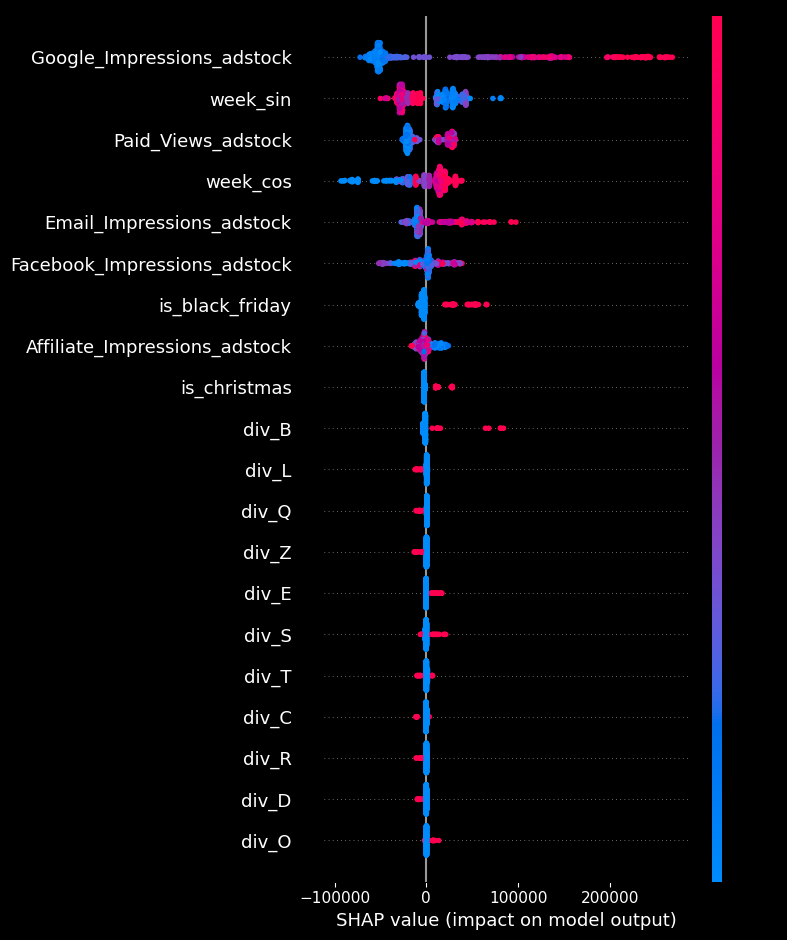

In [34]:
# Prepare SHAP input
X_test_clean = df_test[features_final].copy().astype(np.float64)

# Create SHAP explainer and values
explainer = shap.Explainer(best_model, X_test_clean)
shap_values = explainer(X_test_clean)

# Generate beeswarm plot without showing immediately
shap.summary_plot(shap_values, X_test_clean, plot_type="dot", show=False)

# Apply black background styling
fig = plt.gcf()
fig.patch.set_facecolor('black')
ax = plt.gca()
ax.set_facecolor('black')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
plt.tight_layout()

# Save the plot
plt.savefig("../04_Output/05_Plots/shap_beeswarm.png", dpi=300, facecolor='black')

# Show the final styled plot
plt.show()

## Budget Sensitivity Scenarios

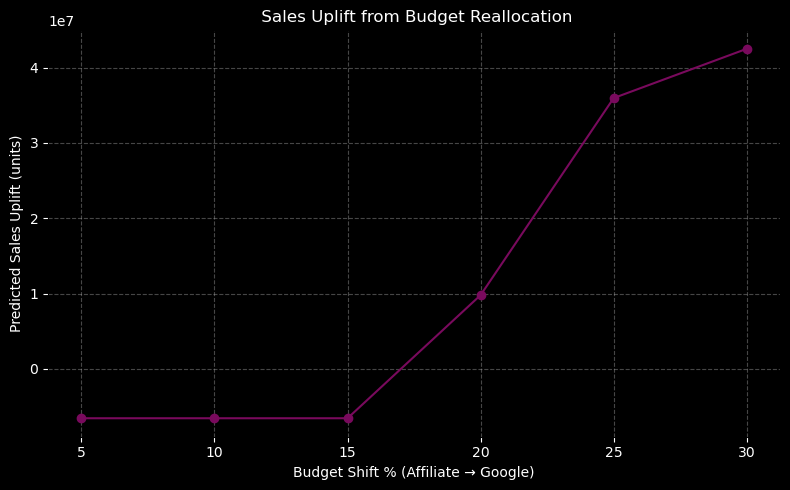

In [35]:
# Shift from Affiliate to Google
source_channel = 'Affiliate_Impressions_adstock'
target_channel = 'Google_Impressions_adstock'

shift_levels = np.arange(0.05, 0.31, 0.05)
uplifts = []

division_means = df.groupby('Division')['Sales'].mean()
df_test['division_mean'] = df_test['Division'].map(division_means)

# Baseline
preds = best_model.predict(X_test)
preds = np.clip(preds, -10, 15)
baseline_sales = np.expm1(preds) + df_test['division_mean']
baseline_total = baseline_sales.sum()

for shift in shift_levels:
    shifted_sales, _ = simulate_budget_shift(
        df_sim=df_test,
        df_full=df,
        original_feature=source_channel,
        target_feature=target_channel,
        shift_percent=shift,
        static_features=static_features,
        model=best_model,
        original_feature_list=features_final
    )
    uplift = shifted_sales - baseline_total
    uplifts.append(uplift)

# Plot
plt.figure(figsize=(8, 5), facecolor='black')
plt.plot(shift_levels * 100, uplifts, marker='o', color='#790A5D')
plt.title(" Sales Uplift from Budget Reallocation", color='white')
plt.xlabel("Budget Shift % (Affiliate → Google)", color='white')
plt.ylabel("Predicted Sales Uplift (units)", color='white')
plt.grid(True, linestyle='--', alpha=0.4)
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='white')
plt.tight_layout()
plt.savefig("../04_Output/05_Plots/budget_uplift_sensitivity.png", dpi=300, facecolor='black')
plt.show()

## SHAP-Based Media Attribution

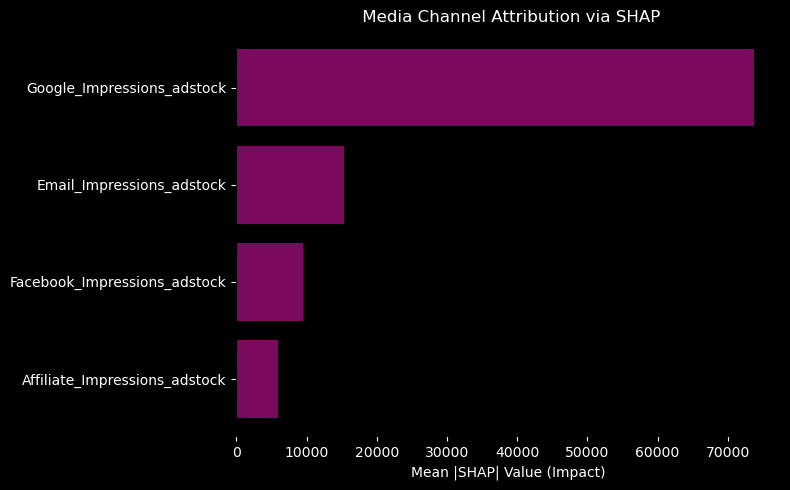

In [36]:
# Ensure test set is clean
X_test_clean = df_test[features_final].copy().astype(np.float64)

# Run SHAP Explainer
explainer = shap.Explainer(best_model, X_test_clean)
shap_values = explainer(X_test_clean)

# Mean absolute SHAP values
shap_df = pd.DataFrame({
    'feature': X_test_clean.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

# Filter to media features only
media_shap = shap_df[shap_df['feature'].str.contains('Impressions_adstock')]

# Plot setup
custom_color = '#790A5D'
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 5), facecolor='black')
ax.barh(media_shap['feature'], media_shap['mean_abs_shap'], color=custom_color)
ax.set_facecolor('black')
ax.set_xlabel("Mean |SHAP| Value (Impact)", color='white')
ax.set_title(" Media Channel Attribution via SHAP", color='white')
ax.tick_params(colors='white')
plt.gca().invert_yaxis()
plt.tight_layout()

# Save to output folder
plt.savefig("../04_Output/05_Plots/shap_media_attribution.png", dpi=300, facecolor='black')

# Show
plt.show()
